In [1]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [2]:
import spatialdata as sd

path_xe = "/cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/data.zarr"
# /cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/data.zarr
# /home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/data.zarr
sdata = sd.read_zarr(path_xe)

/cluster/CBIO/home/lgortana/anaconda3/envs/xenium-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Align sdata with H&E image

In [3]:
from spatialdata_io.readers.xenium import xenium_aligned_image

alignment_matrix_path = "/cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/Xenium_V1_humanLung_Cancer_FFPE_he_imagealignment.csv"

# Path to the H&E image
he_path = "/cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/tif/Xenium_V1_humanLung_Cancer_FFPE_he_image.tif"

image = xenium_aligned_image(he_path, alignment_matrix_path)

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


In [4]:
image_name = "he_image"
sdata.images[image_name] = image

In [5]:
# sdata.write("/home/luca/Documents/data/Xenium_V1_hPancreas_Cancer_Add_on_FFPE/data2.zarr")

## Add segmentation infos (HoverNet)

In [6]:
import json

json_path = "/cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/seg_json/pannuke_fast_mask_lvl3.json"
with open(json_path) as json_file:
    hovernet_dict = json.load(json_file)

In [7]:
import geopandas as gpd
from shapely.geometry import Polygon

cell_ids = []
polygons = []

for cell_id, cell_data in hovernet_dict['nuc'].items():
    contour = cell_data.get('contour', [])
    if contour:
        polygon = Polygon(contour)
        cell_ids.append(cell_id)
        polygons.append(polygon)

gdf = gpd.GeoDataFrame({"geometry": polygons}, index=cell_ids)
gdf.index = [str(i) for i in range(len(gdf))]

In [8]:
from spatialdata.transformations import get_transformation
image_transform = get_transformation(sdata['he_image'])
image_transform

Affine (x, y -> x, y)
    [ 4.78350737e-03  1.28872448e+00 -7.54820225e+01]
    [-1.28872448e+00  4.78350737e-03  1.63091028e+04]
    [0. 0. 1.]

In [9]:
from spatialdata.models import ShapesModel
gdf = ShapesModel.parse(gdf, transformations={"global": image_transform})

In [10]:
sdata.shapes['nucleus_boundaries_hn'] = gdf

# Visualization tools

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.457285659361784].


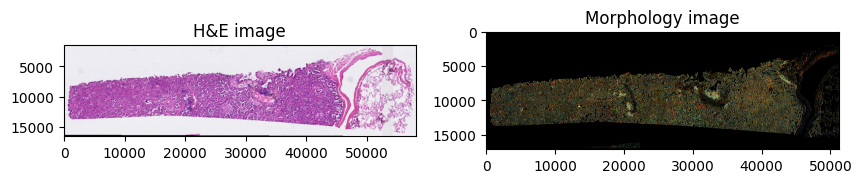

In [11]:
import matplotlib.pyplot as plt
import spatialdata_plot

axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image")
sdata.pl.render_images("morphology_focus").pl.show(ax=axes[1], title="Morphology image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.792156862745098].


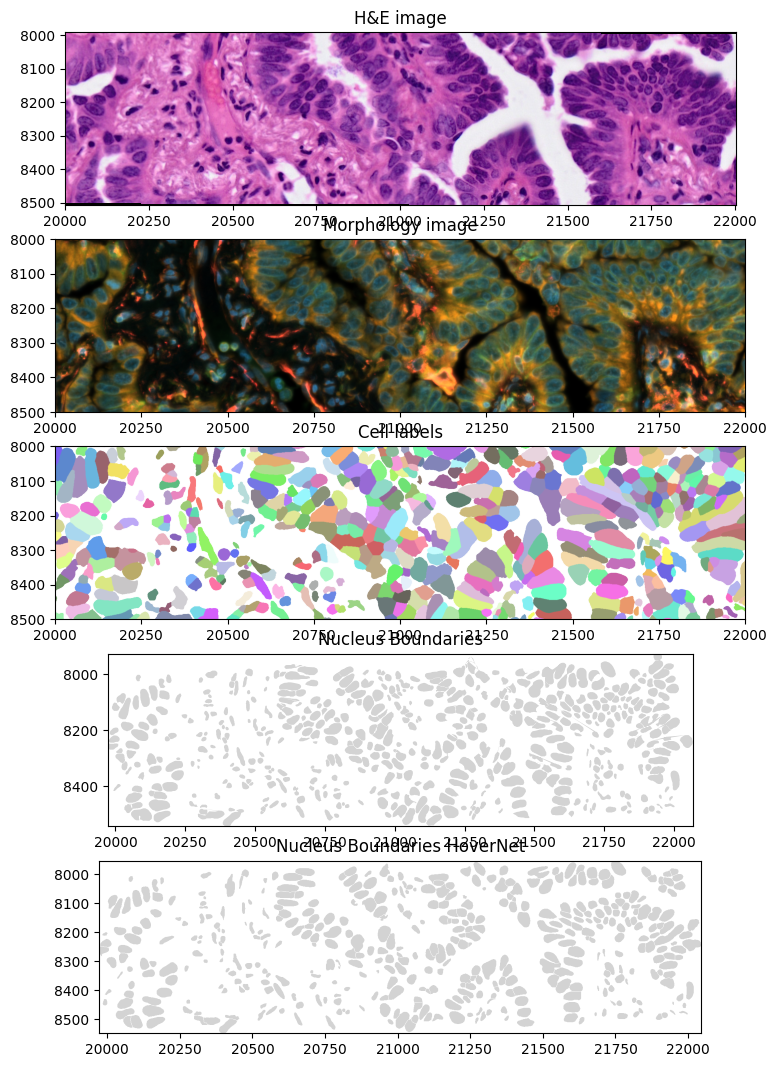

In [12]:
from spatialdata import bounding_box_query

axes = plt.subplots(5, 1, figsize=(20, 13))[1].flatten()
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[20_000, 8000],
    max_coordinate=[22_000, 8500],
    axes=("x", "y"),
    target_coordinate_system="global",
)
crop0(sdata).pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image", coordinate_systems="global")
crop0(sdata).pl.render_images("morphology_focus").pl.show(
    ax=axes[1], title="Morphology image", coordinate_systems="global"
)
crop0(sdata).pl.render_labels("cell_labels").pl.show(ax=axes[2], title="Cell labels", coordinate_systems="global")
crop0(sdata).pl.render_shapes("nucleus_boundaries").pl.show(ax=axes[3], title="Nucleus Boundaries", coordinate_systems="global")
crop0(sdata).pl.render_shapes("nucleus_boundaries_hn").pl.show(ax=axes[4], title="Nucleus Boundaries HoverNet", coordinate_systems="global")

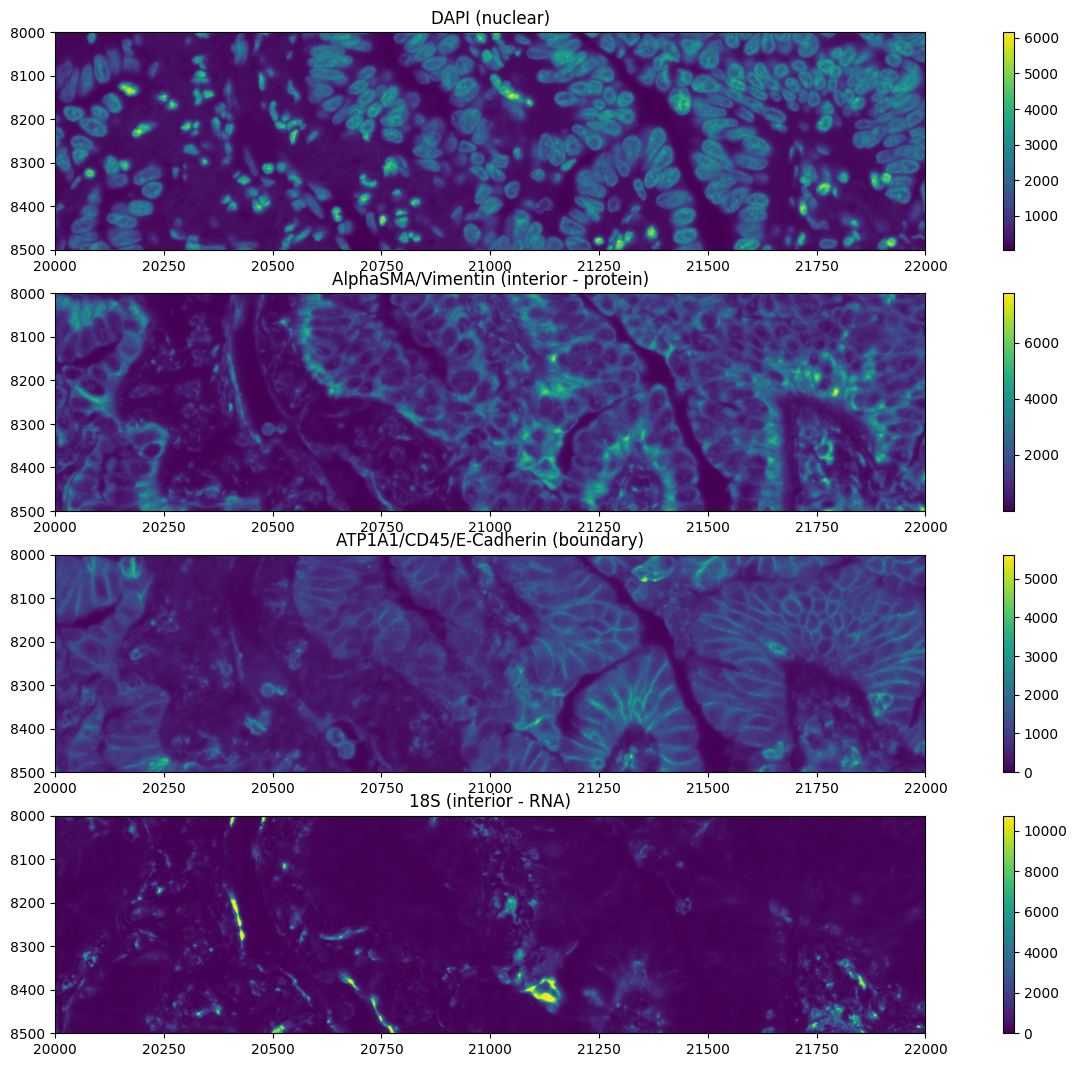

In [13]:
axes = plt.subplots(4, 1, figsize=(20, 13))[1].flatten()

crop0(sdata).pl.render_images("morphology_focus", channel=0).pl.show(ax=axes[0], title="DAPI (nuclear)", figsize=(10, 10))
crop0(sdata).pl.render_images("morphology_focus", channel=1).pl.show(
    ax=axes[1], title="AlphaSMA/Vimentin (interior - protein)", figsize=(10, 10)
)
crop0(sdata).pl.render_images("morphology_focus", channel=2).pl.show(
    ax=axes[2], title="ATP1A1/CD45/E-Cadherin (boundary)", figsize=(10, 10)
)
crop0(sdata).pl.render_images("morphology_focus", channel=3).pl.show(ax=axes[3], title="18S (interior - RNA)", figsize=(10, 10))

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


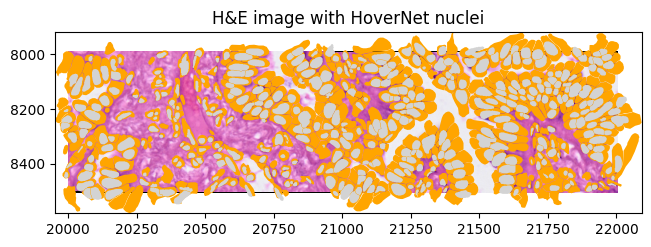

In [14]:
crop0(sdata).pl.render_images(
    "he_image",
    ).pl.render_shapes(
        "cell_boundaries",
        color="orange",
    ).pl.render_shapes(
        "nucleus_boundaries_hn",
    ).pl.show(title="H&E image with HoverNet nuclei", coordinate_systems="global")

# Data pre-processing

## Prepare scRNA-seq data

In [11]:
import anndata

sc_adata_path = "/cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/sc/LuCA_atlas_lung_cancer_filtered.h5ad"
sc_adata = anndata.read_h5ad(sc_adata_path)

In [12]:
color_dict = {
    '0': ['T cell', [0, 150, 0, 255]],
    '1': ['Epithelial cell', [31, 119, 180, 255]],
    '2': ['Macrophage/Monocyte', [0, 170, 140, 255]],
    '3': ['Stromal', [255, 140, 0, 255]],
    '4': ['Plasma cell', [85, 107, 47, 255]],
    '5': ['B cell', [200, 255, 200, 255]],
    '6': ['Endothelial cell', [230, 90, 60, 255]]
}

In [13]:
cell_type_to_remove = ["Mast cell", "cDC", "Neutrophils", "NK cell", "pDC"]
sc_adata = sc_adata[~sc_adata.obs["ann_coarse"].isin(cell_type_to_remove)].copy()

In [14]:
import scanpy as sc

sc.pp.normalize_total(sc_adata)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
print("--> scRNA-seq data loaded.")

--> scRNA-seq data loaded.


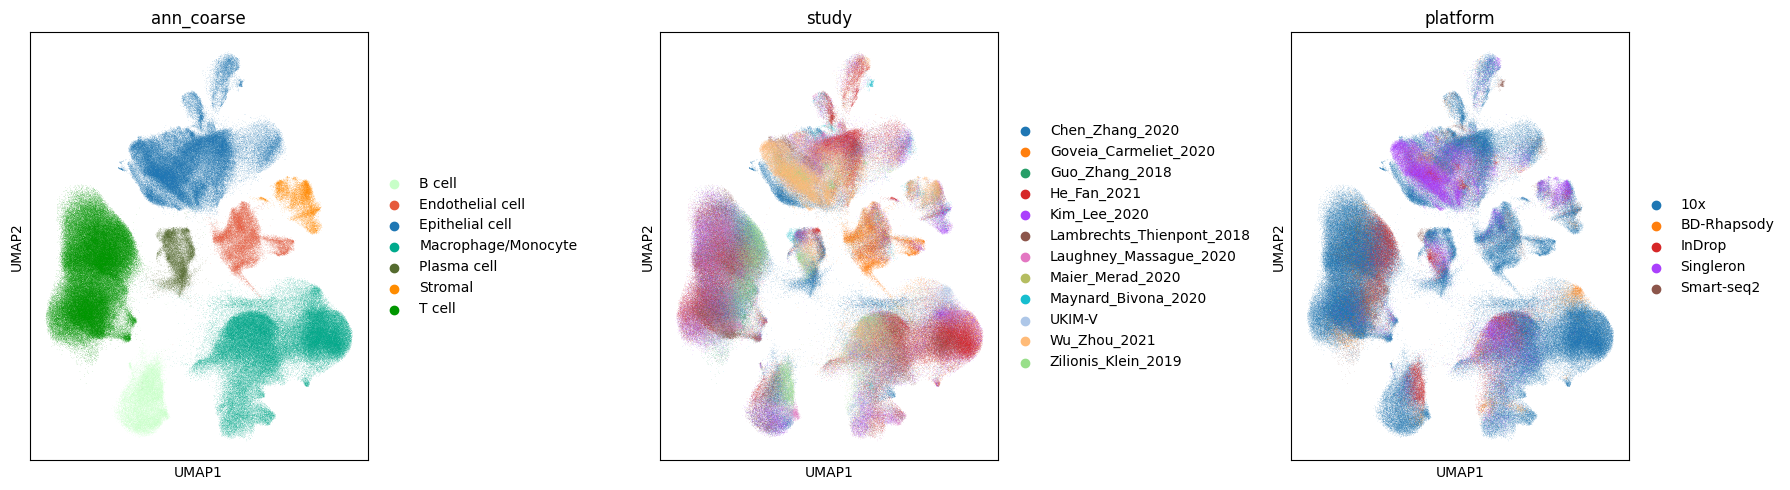

In [17]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

cell_type_colors = {
    v[0]: mcolors.to_hex(np.array(v[1][:3]) / 255)  # normalize RGB to 0–1
    for v in color_dict.values()
}

sc_adata.obs["ann_coarse"] = sc_adata.obs["ann_coarse"].astype("category")

# Assign colors in order of categories
cat_order = sc_adata.obs["ann_coarse"].cat.categories
sc_adata.uns["ann_coarse_colors"] = [
    cell_type_colors.get(cat, "#cccccc")  # fallback gray for missing types
    for cat in cat_order
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sc.pl.umap(sc_adata, color="ann_coarse", ax=axes[0], show=False)
sc.pl.umap(sc_adata, color="study", ax=axes[1], show=False)
sc.pl.umap(sc_adata, color="platform", ax=axes[2], show=False)

plt.tight_layout()
fig.savefig("fig/lung/LuCA_atlas_lung_cancer_umap.png", dpi=500)
plt.show()

## Prepare Xenium data

In [18]:
new_index_name = "gene_ids"
sdata.tables["table"].var["SYMBOL"] = sdata.tables["table"].var_names
sdata.tables["table"].var.set_index(new_index_name, drop=True, inplace=True)
print("-->Variables made unique.")

-->Variables made unique.


In [19]:
import numpy as np

cm_genes = [g for g in sdata.tables["table"].var_names if g in sc_adata.var_names]
xenium_cm = np.array(sdata.tables["table"][:, cm_genes].X.todense())

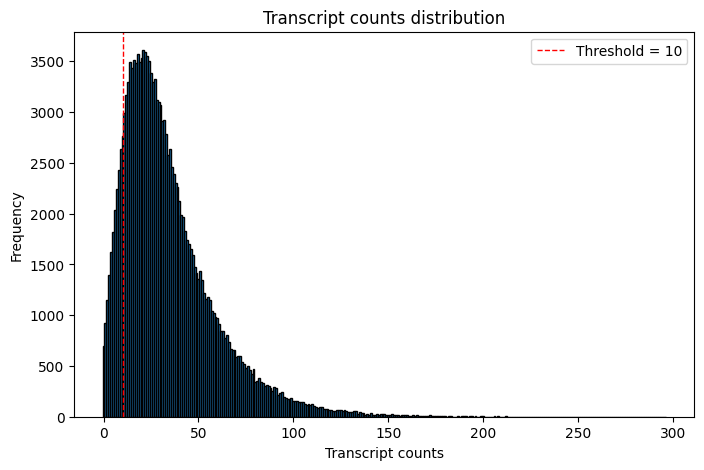

In [22]:
threshold = 10
transcript_counts = xenium_cm.sum(1)
bins = np.arange(transcript_counts.min(), transcript_counts.max() + 2) - 0.5
plt.figure(figsize=(8, 5))
plt.hist(transcript_counts, bins=bins, edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1, label=f"Threshold = {threshold}") 
plt.xlabel("Transcript counts")
plt.ylabel("Frequency")
plt.title("Transcript counts distribution")
plt.legend()
# plt.savefig("fig/lung/transcript_counts_distribution.png", dpi=500)
plt.show()

The threshold is to be used for the annotation step.

In [23]:
xenium_cm_mask = xenium_cm.sum(1) > threshold
xenium_adata_filtered = sdata.tables["table"][xenium_cm_mask].copy()

In [48]:
sc.tl.pca(xenium_adata_filtered)
sc.pp.neighbors(xenium_adata_filtered, use_rep="X_pca")
sc.tl.umap(xenium_adata_filtered)
sc.tl.louvain(xenium_adata_filtered, resolution=0.5)

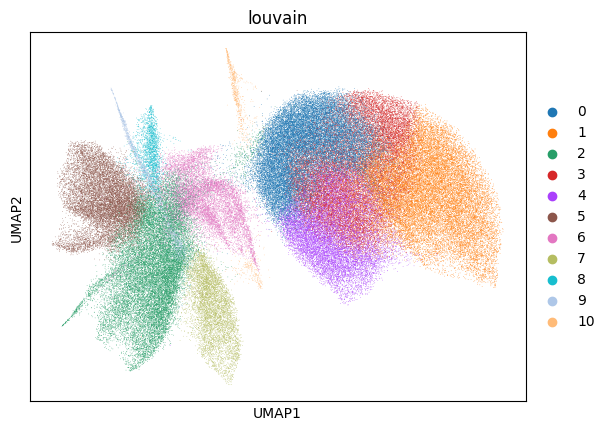

In [23]:
sc.pl.umap(xenium_adata_filtered, color="louvain", wspace=0.35)

# Annotation

## Annotation with Tangram

In [102]:
# import scanpy as sc

# sc.pp.normalize_total(sdata.tables["table"])
# sc.pp.log1p(sdata.tables["table"])
# sc.pp.highly_variable_genes(sdata.tables["table"])

In [103]:
# from sopa.annotation.tangram import tangram_annotate
# tangram_annotate(sdata, sc_adata, "cell_type")

In [104]:
# path_ann = "/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/annotated_data_raw.zarr"
# ann_sdata_norm = sd.read_zarr(path_ann)

In [105]:
# ct_list = ann_sdata_norm.tables["table"].obsm["tangram_pred"].columns.tolist()

In [106]:
# ann_sdata_norm.tables["table"].obs["region"] = "cell_boundaries"
# ann_sdata_norm.set_table_annotates_spatialelement("table", region="cell_boundaries")

# crop0(ann_sdata_norm).pl.render_images("he_image").pl.render_shapes(
#     "cell_boundaries",
#     color="cell_type",
# ).pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

## Annotation with KNN based on cosine distance

The idea is to compute, for all xenium cells, the k-nearest neighbors in the single-cell dataset. To do so, we need to define a distance metric and the ideal candidate is the cosine distance :
$$Dist = 1 - \cos(\theta) = 1 - \frac{A*B}{\rVert{A{\lVert}}*\rVert{B{\lVert}}}$$

For this annotation algorithm, you need to run the cosine_annotation.py file using run_annotation.sh.

In [21]:
import anndata

In [24]:
atlas = "LuCA"
annotated_xenium_adata_path = f"/cluster/CBIO/data1/lgortana/Xenium_V1_humanLung_Cancer_FFPE/sim/{atlas}/cosine_annotation.h5ad"
annotated_xenium_adata = anndata.read_h5ad(annotated_xenium_adata_path)

In [25]:
sdata.tables["table"].obs["cell_type"] = annotated_xenium_adata.obs["cell_type"]
sdata.tables["table"].obsm["annotation_confidence"] = annotated_xenium_adata.obsm["annotation_confidence"]
sdata.tables["table"].obs["cell_type_confidence"] = sdata["table"].obsm["annotation_confidence"].max(axis=1)

In [26]:
ct_list = sdata.tables["table"].obs["cell_type"].unique().tolist()
if "low_counts" in ct_list:
    ct_list.remove("low_counts")
    ct_list.append("low_counts")
ct_list_without_low_counts = [ct for ct in ct_list if ct != "low_counts"]

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata/_core/spatialdata.py:480: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


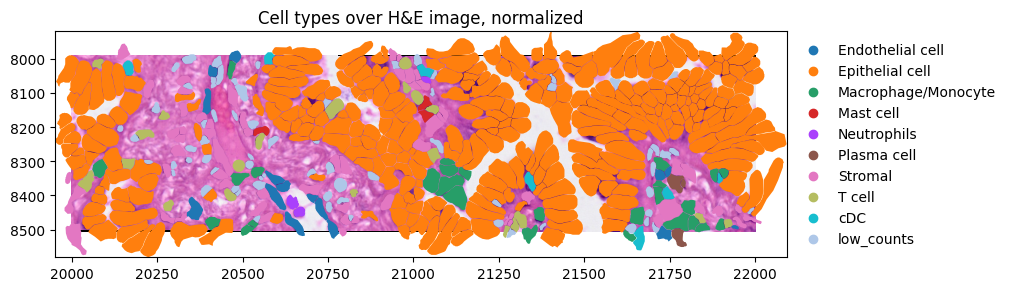

In [18]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

crop0(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color="cell_type",
).pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

If you don't want to load scRNA-seq data, you can still plot the umap on the filtered dataset by uncommenting the following codes :

In [27]:
xenium_cm_mask = sdata.tables["table"].obs["cell_type"] != "low_counts"
xenium_adata_filtered = sdata.tables["table"][xenium_cm_mask].copy()

In [ ]:
# xenium_adata_filtered = xenium_adata_filtered[~xenium_adata_filtered.obs["cell_type"].isin(cell_type_to_remove)].copy()

In [30]:
sc.tl.pca(xenium_adata_filtered)
sc.pp.neighbors(xenium_adata_filtered, use_rep="X_pca")
sc.tl.umap(xenium_adata_filtered)
sc.tl.louvain(xenium_adata_filtered, resolution=0.5)

In [ ]:
# annotated_xenium_adata = annotated_xenium_adata[~annotated_xenium_adata.obs["cell_type"].isin(cell_type_to_remove)].copy()

/tmp/ipykernel_3714669/1559645455.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xenium_adata_filtered.obsm["annotation_confidence"] = annotated_xenium_adata.obsm["annotation_confidence"][xenium_cm_mask]


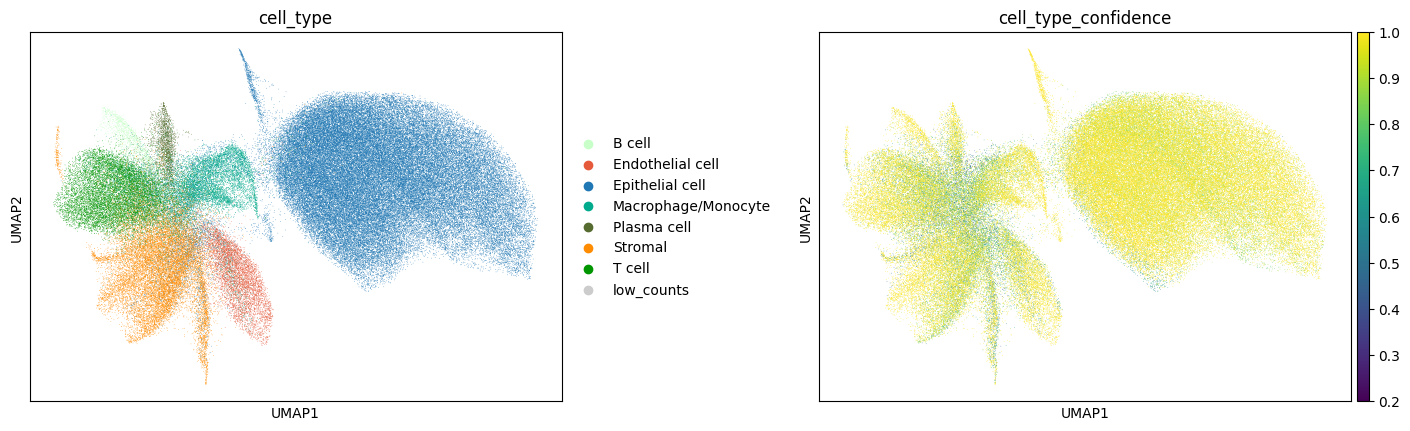

In [33]:
xenium_adata_filtered.obs["cell_type"] = annotated_xenium_adata.obs["cell_type"][xenium_cm_mask].values

cell_type_colors = {
    v[0]: mcolors.to_hex(np.array(v[1][:3]) / 255)  # drop alpha channel, normalize 0-1
    for v in color_dict.values()
}

xenium_adata_filtered.obs["cell_type"] = xenium_adata_filtered.obs["cell_type"].astype("category")

cat_order = xenium_adata_filtered.obs["cell_type"].cat.categories
xenium_adata_filtered.uns["cell_type_colors"] = [
    cell_type_colors.get(cat, "#cccccc")  # fallback gray if not in color_dict
    for cat in cat_order
]


xenium_adata_filtered.obsm["annotation_confidence"] = annotated_xenium_adata.obsm["annotation_confidence"][xenium_cm_mask]
xenium_adata_filtered.obs["cell_type_confidence"] = xenium_adata_filtered.obsm["annotation_confidence"].max(axis=1)

sc.pl.umap(xenium_adata_filtered, color=["cell_type", "cell_type_confidence"], wspace=0.35, save="Xenium_lung_annotated_umap.png")

# Nucleus Matching

## Direct matching hovernet nuclei and cell boundaries

### Transform nucleus and cell coordinates into a common CRS

In [34]:
gdf_nucleus = sdata.shapes["nucleus_boundaries_hn"]
gdf_cells = sdata.shapes["cell_boundaries"]

In [35]:
import utils
affine_matrix = get_transformation(gdf_nucleus).matrix

shapely_affine = (
    affine_matrix[0, 0],  # a
    affine_matrix[0, 1],  # b
    affine_matrix[1, 0],  # d
    affine_matrix[1, 1],  # e
    affine_matrix[0, 2],  # xoff
    affine_matrix[1, 2]   # yoff
)

gdf_nucleus_transformed = gdf_nucleus.copy()
gdf_nucleus_transformed.geometry = utils.apply_transformation_to_gdf(gdf_nucleus_transformed, shapely_affine)

In [36]:
scale_list = get_transformation(gdf_cells).__dict__["scale"].tolist()
scale_x, scale_y = scale_list

shapely_affine2 = (
    scale_x,  # a
    0,  # b
    0,  # d
    scale_y,  # e
    0,  # xoff
    0   # yoff
)

gdf_cells_transformed = gdf_cells.copy()
gdf_cells_transformed.geometry = utils.apply_transformation_to_gdf(gdf_cells_transformed, shapely_affine2)

### Compute intersection

In [183]:
intersections = utils.match_nuclei_and_cells(gdf_nucleus_transformed, gdf_cells_transformed)

In [184]:
overlap = ['0.55', '0.80', '0.85', '0.90', '0.95']
matches = [len(intersections[intersections['overlap_ratio'] >= float(i)]) for i in overlap]

In [95]:
overlap_threshold = 0.55
nuclei_in_cells = utils.filter_matches(intersections,
                                     overlap_threshold=overlap_threshold)
nuclei_in_cells = utils.add_cell_type_to_df(nuclei_in_cells, sdata["table"])
nuclei_in_cells['cell_type_id'] = nuclei_in_cells['cell_type'].map({cell: rank for rank, cell in enumerate(ct_list)})
nuclei_in_cells

nucleus_id     cell_id  overlap_ratio        cell_type  cell_type_id
0       aaaaficg-1  aaaaaaab-1       1.000000           T cell           0.0
1       aaabbaka-1  aaaaaaac-1       0.997385  Epithelial cell           1.0
2       aaabbjoo-1  aaaaaaad-1       1.000000  Epithelial cell           1.0
3       aaablchg-1  aaaaaaae-1       1.000000  Epithelial cell           1.0
4       aaacaicl-1  aaaaaaaf-1       1.000000  Epithelial cell           1.0
...            ...         ...            ...              ...           ...
156621  ojaaphhh-1  aaachjmj-1       1.000000       low_counts           7.0
156622  ojabeldf-1  aaachjmk-1       1.000000       low_counts           7.0
156623  ojacfbid-1  aaachjml-1       1.000000       low_counts           7.0
156624  ojacfhhg-1  aaachjmm-1       1.000000       low_counts           7.0
156625  ojacpeii-1  aaachjmn-1       1.000000       low_counts           7.0

[156626 rows x 5 columns]

## Matching Xenium cells and nuclei before matching them with HoverNet

### Matching Xenium cells and nuclei

In [37]:
gdf_nucleus = sdata.shapes["nucleus_boundaries"]
gdf_cells = sdata.shapes["cell_boundaries"]

In [38]:
import utils
scale_list = get_transformation(gdf_nucleus).__dict__["scale"].tolist()
scale_x, scale_y = scale_list

shapely_affine = (
    scale_x,  # a
    0,  # b
    0,  # d
    scale_y,  # e
    0,  # xoff
    0   # yoff
)

gdf_nucleus_transformed = gdf_nucleus.copy()
gdf_cells_transformed = gdf_cells.copy()
gdf_nucleus_transformed.geometry = utils.apply_transformation_to_gdf(gdf_nucleus_transformed, shapely_affine)
gdf_cells_transformed.geometry = utils.apply_transformation_to_gdf(gdf_cells_transformed, shapely_affine)

In [39]:
intersections = utils.match_nuclei_and_cells(gdf_nucleus_transformed, gdf_cells_transformed)

In [40]:
overlap = ['0.10', '0.50', '0.80', '0.85', '0.90', '0.95']
matches = [len(intersections[intersections['overlap_ratio'] >= float(i)]) for i in overlap]

In [41]:
overlap_threshold = 0.95
nucleus_to_cell = utils.filter_matches(intersections,
                                     overlap_threshold=overlap_threshold)
nucleus_to_cell = utils.add_cell_type_to_df(nucleus_to_cell, sdata["table"])
nucleus_to_cell['cell_type_id'] = nucleus_to_cell['cell_type'].map({cell: rank for rank, cell in enumerate(ct_list)})
nucleus_to_cell

nucleus_id     cell_id  overlap_ratio        cell_type cell_type_id
0       aaaaficg-1  aaaaaaab-1       1.000000           T cell            0
1       aaabbaka-1  aaaaaaac-1       0.997385  Epithelial cell            1
2       aaabbjoo-1  aaaaaaad-1       1.000000  Epithelial cell            1
3       aaablchg-1  aaaaaaae-1       1.000000  Epithelial cell            1
4       aaacaicl-1  aaaaaaaf-1       1.000000  Epithelial cell            1
...            ...         ...            ...              ...          ...
156480  ojaaphhh-1  aaachjmj-1       1.000000       low_counts           12
156481  ojabeldf-1  aaachjmk-1       1.000000       low_counts           12
156482  ojacfbid-1  aaachjml-1       1.000000       low_counts           12
156483  ojacfhhg-1  aaachjmm-1       1.000000       low_counts           12
156484  ojacpeii-1  aaachjmn-1       1.000000       low_counts           12

[156485 rows x 5 columns]

### Matching Xenium nuclei and HoverNet nuclei

In [42]:
gdf_nucleus_hn = sdata.shapes["nucleus_boundaries_hn"]

In [43]:
affine_matrix = get_transformation(gdf_nucleus_hn).matrix

shapely_affine = (
    affine_matrix[0, 0],  # a
    affine_matrix[0, 1],  # b
    affine_matrix[1, 0],  # d
    affine_matrix[1, 1],  # e
    affine_matrix[0, 2],  # xoff
    affine_matrix[1, 2]   # yoff
)

gdf_nucleus_hn_transformed = gdf_nucleus_hn.copy()
gdf_nucleus_hn_transformed.geometry = utils.apply_transformation_to_gdf(gdf_nucleus_hn_transformed, shapely_affine)

In [44]:
nucleus_to_nucleus = utils.find_closest_nucleus(gdf_nucleus_transformed, gdf_nucleus_hn_transformed)

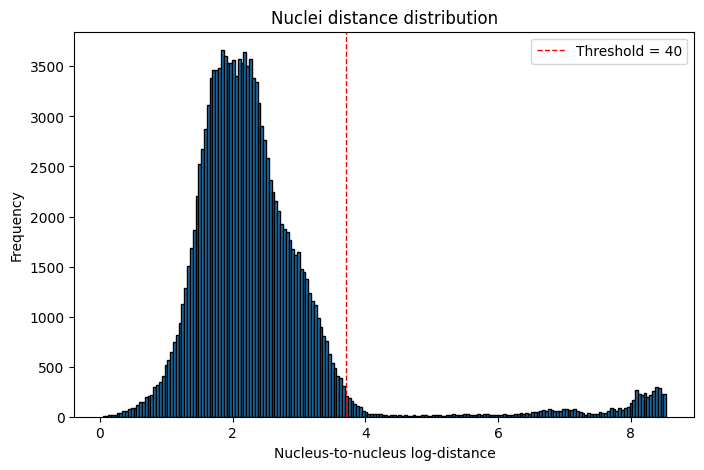

In [45]:
import numpy as np

threshold = 40
bins = 200
log_distances = np.log(nucleus_to_nucleus["distance"]+1)
plt.figure(figsize=(8, 5))
plt.hist(log_distances, bins=bins, edgecolor='black')
plt.axvline(x=np.log(threshold+1), color='red', linestyle='--', linewidth=1, label=f"Threshold = {threshold}") 
plt.xlabel("Nucleus-to-nucleus log-distance")
plt.ylabel("Frequency")
plt.title("Nuclei distance distribution")
plt.legend()
# plt.savefig("fig/lung/nuclei_distance_distribution.png", dpi=500)
plt.show()

In [46]:
nucleus_to_nucleus["nucleus_hn_id"] = nucleus_to_nucleus.index.astype(str)
nucleus_to_nucleus = nucleus_to_nucleus[nucleus_to_nucleus['distance'] < threshold]
nucleus_to_nucleus = nucleus_to_nucleus.loc[nucleus_to_nucleus.groupby('nucleus_id')['distance'].idxmin()]
nuclei_in_cells = nucleus_to_nucleus.merge(nucleus_to_cell, on='nucleus_id', how='inner')
nuclei_in_cells = nuclei_in_cells.reindex(columns=["nucleus_hn_id", "cell_id", "distance", "cell_type", "cell_type_id"])
nuclei_in_cells = nuclei_in_cells.rename(columns={"nucleus_hn_id": "nucleus_id"})
nuclei_in_cells

nucleus_id     cell_id   distance        cell_type cell_type_id
0           38383  aaaaaald-1  10.271059       low_counts           12
1           38424  aaaaaale-1   1.733830  Epithelial cell            1
2           38414  aaaaaalf-1   6.174713  Epithelial cell            1
3           38399  aaaaaalg-1  14.608740  Epithelial cell            1
4           38394  aaaaaalh-1   3.863427  Epithelial cell            1
...           ...         ...        ...              ...          ...
120551      92285  aaachjlm-1   3.538240           T cell            0
120552      92338  aaachjlp-1   5.210998       low_counts           12
120553      96697  aaachjmc-1   8.520217      Plasma cell            7
120554      96413  aaachjmf-1   5.042154       low_counts           12
120555      96044  aaachjmi-1   4.653010       low_counts           12

[120556 rows x 5 columns]

## Check nucleus-cell matching

In [ ]:
crop1 = lambda x: bounding_box_query(
    x,
    min_coordinate=[24_000, 8000],
    max_coordinate=[24_200, 8100],
    axes=("x", "y"),
    target_coordinate_system="global",
)

crop1(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color="cell_id",
).pl.render_shapes(
    "nucleus_boundaries_hn",
).pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

In [ ]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

crop1(sdata).pl.render_images("he_image").pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

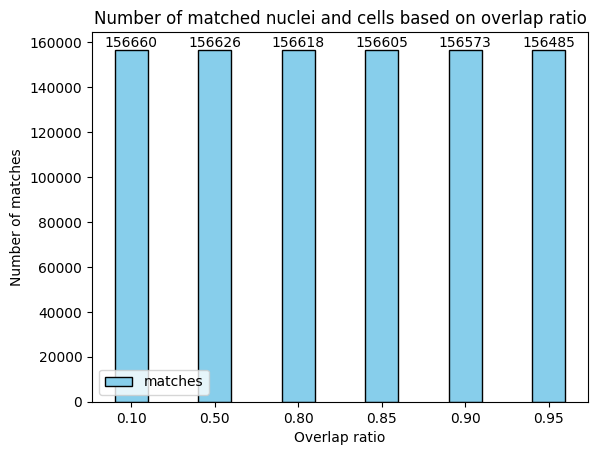

In [40]:
plt.bar(overlap, matches, color='skyblue', edgecolor='black', width=0.4, label='matches')

plt.title("Number of matched nuclei and cells based on overlap ratio")
plt.xlabel("Overlap ratio")
plt.ylabel("Number of matches")

for ol, m in zip(overlap, matches):
    plt.text(ol, m + 0.5, str(m), ha='center', va='bottom', fontsize=10)

plt.legend()
plt.show()

# Simulate Visium spots

## Define the grid

In [47]:
from spatialdata import get_extent

extent = get_extent(sdata)
extent

{'y': (0.0, 17098.0),
 'x': (-75.48202253664931, 58084.631446806256),
 'z': (4.722587585449219, 32.925540924072266)}

<Axes: >

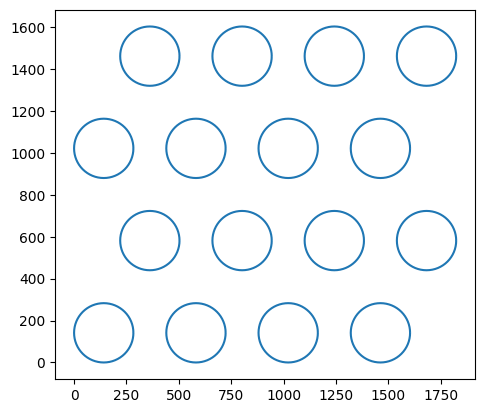

In [29]:
example = utils.make_spot_grid(
    x_min=0,
    x_max=2000,
    y_min=0,
    y_max=2000,
    diameter=283,
    spacing=440)
example.boundary.plot()

In [48]:
spot_orga = "real"
diameter = 283
if spot_orga == "real":
    spacing = 440
else:
    spacing = 290

gdf_spots = utils.make_spot_grid(
    x_min=extent["x"][0].item(),
    x_max=extent["x"][1].item(),
    y_min=extent["y"][0].item(),
    y_max=extent["y"][1].item(),
    diameter=diameter,
    spacing=spacing
)

sdata.shapes["pseudo_spots"] = gdf_spots

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


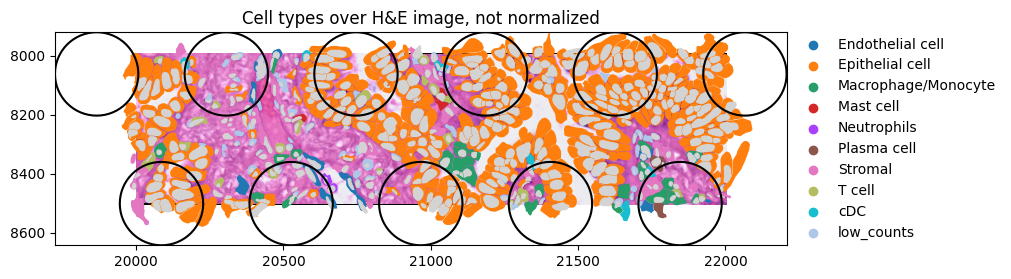

In [31]:
crop0(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color="cell_type",
).pl.render_shapes(
    "nucleus_boundaries_hn",
).pl.render_shapes(
    "pseudo_spots",
    fill_alpha=0,
    outline_alpha=1,
    outline_color="black",
).pl.show(title=f"Cell types over H&E image, not normalized", coordinate_systems="global", figsize=(10, 5))

## Match nuclei and spots

In [49]:
gdf_nucleus = sdata.shapes["nucleus_boundaries_hn"]
nuclei_in_spots = utils.match_nuclei_in_spots(gdf_spots, gdf_nucleus)
nuclei_in_spots

nucleus_id spot_id
0             72    4301
1             76    4350
2             80    4350
3             81    4350
4             92    4614
...          ...     ...
45789     141238    1812
45790     141240    1812
45791     141249    1812
45792     141250    1812
45793     141251    1812

[45794 rows x 2 columns]

In [50]:
pseudo_data = nuclei_in_cells[nuclei_in_cells["nucleus_id"].isin(nuclei_in_spots["nucleus_id"])]
pseudo_data = pseudo_data.merge(nuclei_in_spots[["nucleus_id", "spot_id"]], on="nucleus_id", how="left")
pseudo_data = pseudo_data.reindex(columns=["nucleus_id", "cell_id", "spot_id", "overlap_ratio", "cell_type", "cell_type_id"])
pseudo_data = pseudo_data[pseudo_data["cell_type"] != "low_counts"]
if pseudo_data["cell_type"].dtype.name == "category":
    pseudo_data["cell_type"] = pseudo_data["cell_type"].cat.remove_categories(["low_counts"])

## Rearrange cell types

We can remove some cell types :

In [51]:
cell_type_to_remove = ["Mast cell", "cDC", "Neutrophils", "NK cell", "pDC"]
pseudo_data = pseudo_data[~pseudo_data["cell_type"].isin(cell_type_to_remove)]
pseudo_data["cell_type"] = pseudo_data["cell_type"].cat.remove_unused_categories()
pseudo_data["cell_type_id"] = pseudo_data["cell_type_id"].cat.remove_unused_categories()
pseudo_data

nucleus_id     cell_id spot_id  overlap_ratio        cell_type  \
0          38394  aaaaaalh-1    2644            NaN  Epithelial cell   
2          38410  aaaaaall-1    2644            NaN  Epithelial cell   
3          38428  aaaaaalm-1    2644            NaN  Epithelial cell   
5          38455  aaaaaalo-1    2644            NaN  Epithelial cell   
6          38349  aaaaaalp-1    2644            NaN  Epithelial cell   
...          ...         ...     ...            ...              ...   
38941      49432  aaachjho-1    2820            NaN  Epithelial cell   
38942     128231  aaachjid-1    2819            NaN           T cell   
38943      50447  aaachjii-1    2955            NaN          Stromal   
38944      24419  aaachjip-1    3879            NaN  Epithelial cell   
38947      50675  aaachjkp-1    2823            NaN  Epithelial cell   

      cell_type_id  
0                1  
2                1  
3                1  
5                1  
6                1  
...            ...  
38941            1  
38942            0  
38943            5  
38944            1  
38947            1  

[34716 rows x 6 columns]

In [52]:
unique_ids = sorted(pseudo_data["cell_type_id"].unique())
id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
pseudo_data["cell_type_id"] = pseudo_data["cell_type_id"].map(id_mapping)

In [53]:
nuclei_in_cells = nuclei_in_cells[~nuclei_in_cells["cell_type"].isin(cell_type_to_remove)]
nuclei_in_cells["cell_type"] = nuclei_in_cells["cell_type"].cat.remove_unused_categories()
nuclei_in_cells["cell_type_id"] = nuclei_in_cells["cell_type_id"].cat.remove_unused_categories()

/tmp/ipykernel_3714669/4044170826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclei_in_cells["cell_type"] = nuclei_in_cells["cell_type"].cat.remove_unused_categories()
/tmp/ipykernel_3714669/4044170826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclei_in_cells["cell_type_id"] = nuclei_in_cells["cell_type_id"].cat.remove_unused_categories()


In [54]:
unique_ids = sorted(nuclei_in_cells["cell_type_id"].unique())
id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
nuclei_in_cells["cell_type_id"] = nuclei_in_cells["cell_type_id"].map(id_mapping)

/tmp/ipykernel_3714669/4194540238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclei_in_cells["cell_type_id"] = nuclei_in_cells["cell_type_id"].map(id_mapping)


In [55]:
ct_list = [ct for ct in ct_list if ct not in cell_type_to_remove]
ct_list_without_low_counts = [ct for ct in ct_list_without_low_counts if ct not in cell_type_to_remove]

And/or change cell types by grouping current cell types into subgroups :

In [61]:
cell_type_mapping = {
    'Epithelial cell': 'neopla',
    'Stromal': 'connec',
    'T cell': 'inflam',
    'Macrophage/Monocyte': 'inflam',
    'Endothelial cell': 'connec',
    'Plasma cell': 'inflam',
    'B cell': 'inflam',
    'low_counts': 'low_counts',
}

ct_list = ['neopla', 'inflam', 'connec', 'low_counts']
ct_list_without_low_counts = ['neopla', 'inflam', 'connec']

In [62]:
cell_type_to_id = {ct: idx for idx, ct in enumerate(ct_list_without_low_counts)}
pseudo_data['cell_type'] = pseudo_data['cell_type'].map(cell_type_mapping)
pseudo_data['cell_type_id'] = pseudo_data['cell_type'].map(cell_type_to_id)

In [63]:
cell_type_to_id = {ct: idx for idx, ct in enumerate(ct_list)}
nuclei_in_cells['cell_type'] = nuclei_in_cells['cell_type'].map(cell_type_mapping)
nuclei_in_cells['cell_type_id'] = nuclei_in_cells['cell_type'].map(cell_type_to_id)

/tmp/ipykernel_3714669/708743712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclei_in_cells['cell_type'] = nuclei_in_cells['cell_type'].map(cell_type_mapping)
/tmp/ipykernel_3714669/708743712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclei_in_cells['cell_type_id'] = nuclei_in_cells['cell_type'].map(cell_type_to_id)


In [64]:
color_dict = {
    '0': ['neopla', [31, 119, 180, 255]],
    '1': ['inflam', [0, 170, 140, 255]],
    '2': ['connec', [255, 140, 0, 255]]
}

## Check matching

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


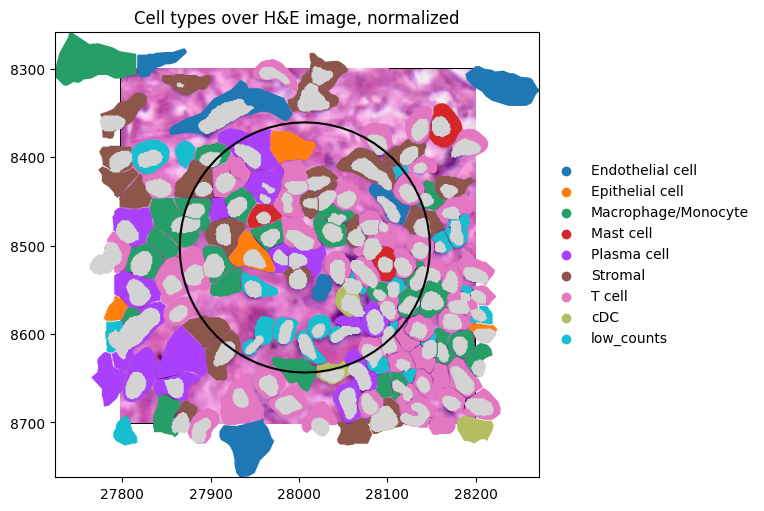

In [129]:
crop2 = lambda x: bounding_box_query(
    x,
    min_coordinate=[27_800, 8300],
    max_coordinate=[28_200, 8700],
    axes=("x", "y"),
    target_coordinate_system="global",
)

crop2(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color="cell_type",
).pl.render_shapes(
    "nucleus_boundaries_hn",
).pl.render_shapes(
    "pseudo_spots",
    fill_alpha=0,
    outline_alpha=1,
    outline_color="black",
).pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

In [103]:
spot_index = crop2(sdata)["pseudo_spots"].index.values[0]
inside_spot = pseudo_data[pseudo_data["spot_id"] == spot_index]
inside_spot

nucleus_id     cell_id spot_id  overlap_ratio         cell_type  \
10405     118677  aaaajkfe-1    2570            NaN   Epithelial cell   
10406     118670  aaaajkff-1    2570            NaN   Epithelial cell   
10407     118672  aaaajkfh-1    2570            NaN   Epithelial cell   
10408     118664  aaaajkfi-1    2570            NaN   Epithelial cell   
10409     118668  aaaajkfl-1    2570            NaN   Epithelial cell   
10417     118663  aaaajkha-1    2570            NaN   Epithelial cell   
10418     118660  aaaajkhd-1    2570            NaN   Epithelial cell   
10419     118681  aaaajkhi-1    2570            NaN            T cell   
36486     118667  aaaceoee-1    2570            NaN            T cell   
36487     118661  aaaceoeh-1    2570            NaN   Epithelial cell   
36488     118666  aaaceoei-1    2570            NaN   Epithelial cell   
36489     118682  aaaceoen-1    2570            NaN         Mast cell   
36490     118674  aaaceoep-1    2570            NaN           Stromal   
36491     118678  aaaceofa-1    2570            NaN  Endothelial cell   
36492     118676  aaaceofb-1    2570            NaN  Endothelial cell   
36493     118673  aaaceofe-1    2570            NaN           Stromal   
36494     118671  aaaceoff-1    2570            NaN           Stromal   
36508     118684  aaaceojc-1    2570            NaN  Endothelial cell   
36509     118669  aaaceojm-1    2570            NaN   Epithelial cell   

      cell_type_id  
10405            1  
10406            1  
10407            1  
10408            1  
10409            1  
10417            1  
10418            1  
10419            0  
36486            0  
36487            1  
36488            1  
36489            4  
36490            5  
36491           10  
36492           10  
36493            5  
36494            5  
36508           10  
36509            1

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/geopandas/geoseries.py:720: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


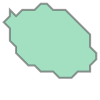

In [140]:
from shapely.affinity import rotate, scale

nucleus_id = 118791
nucleus_shape = sdata["nucleus_boundaries_hn"][sdata["nucleus_boundaries_hn"].index == str(nucleus_id)]
nucleus_shape_copy = nucleus_shape.copy()
nucleus_shape_copy = nucleus_shape_copy["geometry"].apply(lambda geom: scale(geom, xfact=1, yfact=-1, origin="center"))
nucleus_shape_copy = nucleus_shape_copy.apply(lambda geom: rotate(geom, angle=90, origin="center"))
nucleus_shape_copy[0]

## Analyze pseudo data

In [65]:
len(pseudo_data), len(pseudo_data["spot_id"].unique())

(34716, 1957)

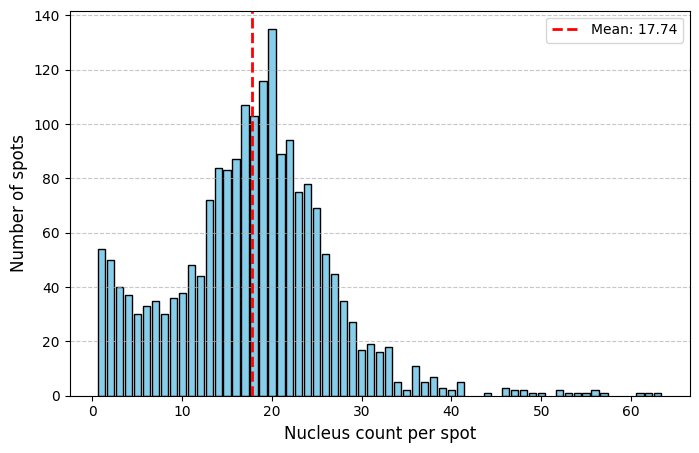

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
utils.histogram_per_spot(pseudo_data,
                         ax=ax,
                         title = "",
                         show_mean=True)

# plt.savefig("fig/lung/nucleus_counts_per_spot.png", dpi=500)

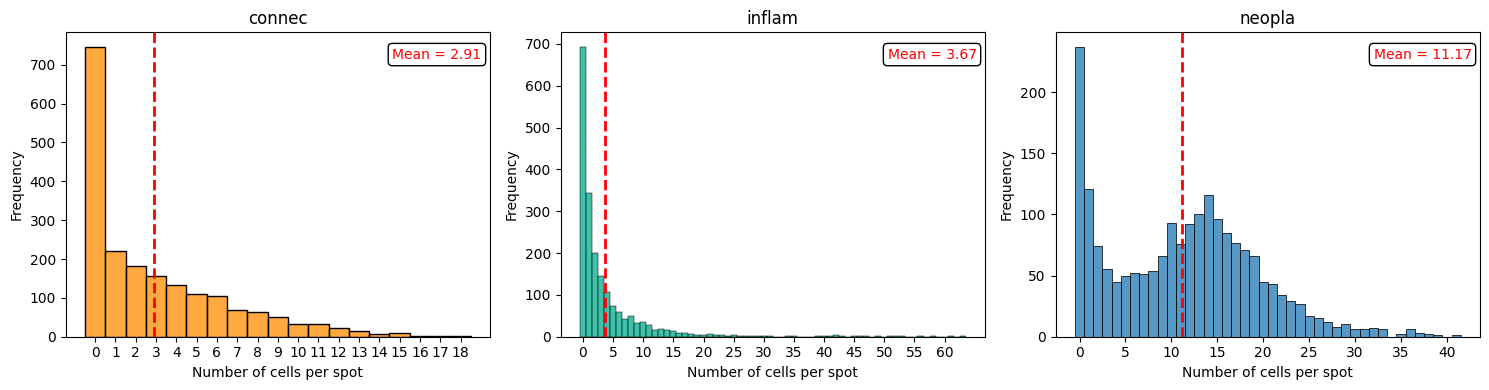

In [67]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Compute counts of cells per (spot_id, cell_type)
counts = (
    pseudo_data.groupby(["spot_id", "cell_type"])
    .size()
    .unstack(fill_value=0)  # rows = spots, cols = cell types
)

cell_types = counts.columns
n_types = len(cell_types)

n_cols = math.ceil(math.sqrt(n_types))
n_rows = math.ceil(n_types / n_cols)

color_map = {
    v[0]: tuple(np.array(v[1][:3]) / 255)
    for v in color_dict.values()
}

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
fig, axes = plt.subplots(1, 3, figsize=(3 * 5, 1 * 4))
axes = axes.flatten()

# Cell types for which we only want sparse x-ticks
sparse_xtick_types = ["B cell", "Epithelial cell", "T cell", 'neopla', 'inflam']

for idx, cell_type in enumerate(cell_types):
    ax = axes[idx]
    data = counts[cell_type]
    mean_val = data.mean()

    # Define integer bins (one per cell count)
    max_val = int(data.max())
    bins = np.arange(-0.5, max_val + 1.5, 1)

    # Plot histogram
    color = color_map.get(cell_type)
    sns.histplot(data, bins=bins, ax=ax, color=color, edgecolor="black")

    # Vertical line for the mean
    ax.axvline(mean_val, color="red", linestyle="--", linewidth=2)

    # Mean value box in top-right corner
    ax.text(
        0.98, 0.95, f"Mean = {mean_val:.2f}",
        transform=ax.transAxes,
        ha="right", va="top",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
        fontsize=10, color="red"
    )

    ax.set_title(cell_type)
    ax.set_xlabel("Number of cells per spot")
    ax.set_ylabel("Frequency")

    # X-axis ticks: all integers, but sparse for some cell types
    if cell_type in sparse_xtick_types:
        step = 5
        ax.set_xticks(np.arange(0, max_val + 1, step))
    else:
        ax.set_xticks(range(max_val + 1))

# Turn off any extra subplots
for ax in axes[len(cell_types):]:
    ax.axis("off")

plt.tight_layout()
plt.savefig("fig/lung/cell_type_distribution_per_spot_3_types.png", dpi=500)
plt.show()

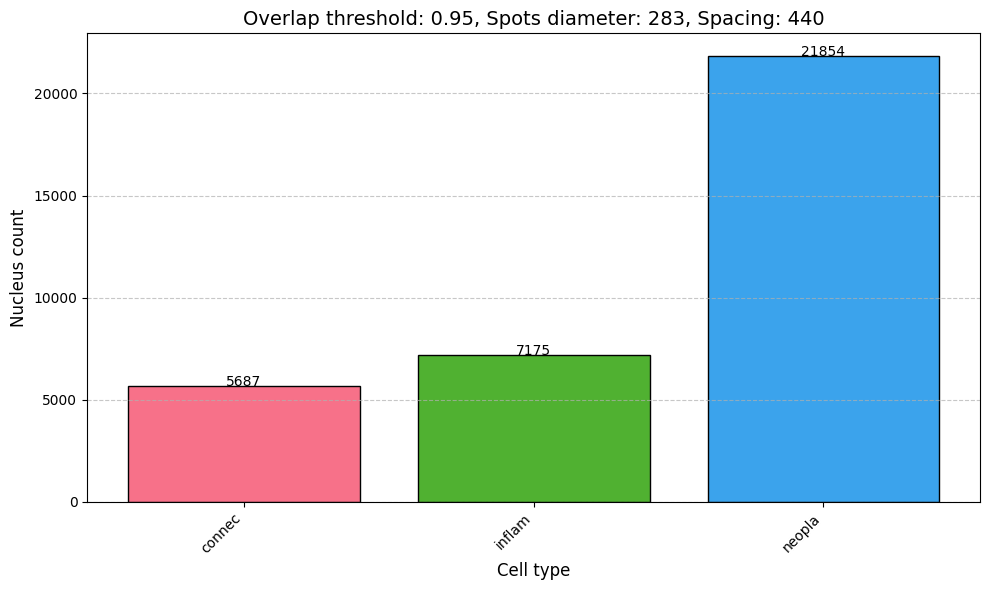

In [48]:
nucleus_per_cell_type = pseudo_data.groupby("cell_type").size()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    nucleus_per_cell_type.index, 
    nucleus_per_cell_type.values, 
    color=palette,
    edgecolor="black"
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        str(height),
        ha="center",
        fontsize=10
    )

plt.xlabel("Cell type", fontsize=12)
plt.ylabel("Nucleus count", fontsize=12)
plt.title(f"Overlap threshold: {overlap_threshold}, Spots diameter: {diameter}, Spacing: {spacing}", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

# Save pseudo data

## AnnData with spot coordinates

In [49]:
transformation = get_transformation(sdata["nucleus_boundaries_hn"])
inverse_transformation = transformation.inverse() 

inverse_affine_matrix = (
    inverse_transformation.matrix[0, 0],  # a
    inverse_transformation.matrix[0, 1],  # b
    inverse_transformation.matrix[1, 0],  # d
    inverse_transformation.matrix[1, 1],  # e
    inverse_transformation.matrix[0, 2],  # xoff
    inverse_transformation.matrix[1, 2]   # yoff
)

transformed_geometries = utils.apply_transformation_to_gdf(gdf_spots, inverse_affine_matrix)
transformed_geometries.total_bounds

array([ -538.02224571,   -46.56567909, 12821.47557951, 45116.40557136])

In [50]:
spots_df = utils.spot_gdf_to_df(transformed_geometries)
spots_df = spots_df[spots_df.index.isin(pseudo_data["spot_id"])]

In [51]:
from anndata import AnnData

pseudo_adata = AnnData()
pseudo_adata.obs.index = spots_df.index
pseudo_adata.obs["spot_id"] = spots_df.index
pseudo_adata.obsm["spatial"]=spots_df[["x_center", "y_center"]].values.astype(int)
pseudo_adata.uns["spatial"]={"Xenium_V1_humanLung_Cancer_FFPE":
                             {"scalefactors" : 
                              {"spot_diameter_fullres" : spots_df["diameter"].values[0]}}}

Let's save the pseudo anndata object :

In [52]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/pseudo_adata_{spot_orga}.h5ad"
pseudo_adata.write_h5ad(output_path)

## Spot proportions

In [53]:
cell_counts = pseudo_data.groupby(["spot_id", "cell_type"]).size().reset_index(name="count")
total_counts = cell_counts.groupby("spot_id")["count"].transform("sum")
cell_counts["proportion"] = cell_counts["count"] / total_counts
spot_prop_df = cell_counts.pivot(index="spot_id", columns="cell_type", values="proportion").fillna(0)
spot_prop_df = spot_prop_df.reindex(columns=ct_list_without_low_counts)
spot_prop_df.index.name = None
spot_prop_df.columns.name = None
spot_prop_df

neopla  inflam    connec
1028  1.000000     0.0  0.000000
1029  0.500000     0.0  0.500000
1031  0.333333     0.0  0.666667
1033  0.000000     0.0  1.000000
1034  0.000000     0.0  1.000000
...        ...     ...       ...
775   0.000000     0.0  1.000000
901   0.000000     0.0  1.000000
902   0.000000     0.0  1.000000
906   1.000000     0.0  0.000000
907   0.000000     0.0  1.000000

[1957 rows x 3 columns]

Let's save the dataframe with spot proportions :

In [54]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/sim_Xenium_V1_humanLung_Cancer_FFPE_prop_{spot_orga}.csv"
spot_prop_df.to_csv(output_path, index=True)

## Ground Truth for each nucleus
### If no confidence is given

In [58]:
ground_truth = nuclei_in_cells.pivot_table(
    index="nucleus_id",
    columns="cell_type",
    values="cell_id",
    aggfunc=lambda x: 1,
    fill_value=0,
)
ground_truth = ground_truth.reindex(columns=ct_list)
ground_truth.columns.name = None
ground_truth.index = ground_truth.index.astype(int)
ground_truth = ground_truth.sort_index()
ground_truth.index = ground_truth.index.astype(str)
ground_truth = ground_truth[ground_truth["low_counts"] != 1].drop(columns=["low_counts"])
ground_truth

neopla  inflam  connec
nucleus_id                        
0                1       0       0
1                1       0       0
2                0       0       1
3                1       0       0
4                1       0       0
...            ...     ...     ...
141251           0       0       1
141252           0       1       0
141254           0       1       0
141255           0       1       0
141256           0       0       1

[107429 rows x 3 columns]

### If confidence is given

In [55]:
import pandas as pd

annotation_confidence = annotated_xenium_adata.obsm["annotation_confidence"]
df_merged = pd.merge(
    nuclei_in_cells,
    annotation_confidence,
    left_on='cell_id',
    right_index=True,
    how='inner'
)
ground_truth = df_merged.set_index('nucleus_id')[annotation_confidence.columns]
ground_truth = ground_truth.reindex(columns=ct_list)
ground_truth.index = ground_truth.index.astype(int)
ground_truth = ground_truth.sort_index()
ground_truth.index = ground_truth.index.astype(str)
ground_truth = ground_truth[ground_truth["low_counts"] != 1].drop(columns=["low_counts"])
ground_truth

neopla  inflam  connec
nucleus_id                        
0              NaN     NaN     NaN
1              NaN     NaN     NaN
2              NaN     NaN     NaN
3              NaN     NaN     NaN
4              NaN     NaN     NaN
...            ...     ...     ...
141251         NaN     NaN     NaN
141252         NaN     NaN     NaN
141254         NaN     NaN     NaN
141255         NaN     NaN     NaN
141256         NaN     NaN     NaN

[107429 rows x 3 columns]

In [59]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/sim_Xenium_V1_humanLung_Cancer_FFPE_gt.csv"
ground_truth.to_csv(output_path, index=True)

## HoverNet dictionnary with Xenium annotations

In [60]:
nucleus_ids = list(map(int, hovernet_dict['nuc'].keys()))
id_mapping = {str(old_id): str(new_id) for new_id, old_id in enumerate(nucleus_ids)}
pseudo_dict = hovernet_dict.copy()
pseudo_dict['nuc'] = {id_mapping[k]: v for k, v in hovernet_dict['nuc'].items()}

nucleus_to_type = nuclei_in_cells.set_index('nucleus_id')['cell_type_id'].to_dict()

default_type = len(ct_list_without_low_counts)+1 #cells removed when matching or when removing cell types
for nucleus_id, values in pseudo_dict['nuc'].items():
    values['type'] = nucleus_to_type.get(nucleus_id, default_type)

Let's save the hovernet dictionnary with all the annotations :

In [73]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/pannuke_fast_mask_lvl3_annotated.json"
with open(output_path, 'w') as json_file:
    json.dump(pseudo_dict, json_file)

## Cell to spot dictionnary

### Inside cells

In [74]:
from collections import defaultdict

spot_dict = defaultdict(list)
for spot_id, group in pseudo_data.groupby("spot_id"):
    spot_dict[str(spot_id)] = [str(nucleus_id) for nucleus_id in group["nucleus_id"].tolist()]

In [75]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/spot_dict_{spot_orga}.json"
with open(output_path, "w") as file:
    json.dump(dict(spot_dict), file)

### Closest spots

In [76]:
gdf_spots_final = gdf_spots[gdf_spots.index.isin(spot_dict.keys())]
nuclei_to_closest_spots = utils.match_nuclei_to_closest_spots(gdf_nucleus, gdf_spots_final)
nuclei_to_closest_spots = nuclei_to_closest_spots[nuclei_to_closest_spots["nucleus_id"].isin(ground_truth.index)]
nuclei_to_closest_spots

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


nucleus_id spot_id    distance
0               0    4165  222.312220
1               1    4165  174.795174
2               2    4165  186.413472
3               3    4165  286.303661
4               4    4166  243.871913
...           ...     ...         ...
141251     141251    1812   39.375416
141252     141252    1812  250.566436
141254     141254    1944  231.371834
141255     141255    1812  259.471169
141256     141256    1944  246.243715

[107429 rows x 3 columns]

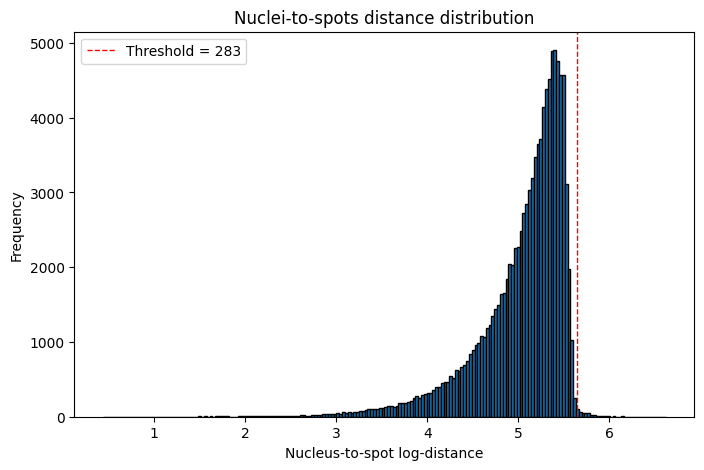

In [77]:
bins = 200
log_distances = np.log(nuclei_to_closest_spots["distance"]+1)
plt.figure(figsize=(8, 5))
plt.hist(log_distances, bins=bins, edgecolor='black')
plt.axvline(x=np.log(diameter+1), color='red', linestyle='--', linewidth=1, label=f"Threshold = {diameter}") 
plt.xlabel("Nucleus-to-spot log-distance")
plt.ylabel("Frequency")
plt.title("Nuclei-to-spots distance distribution")
plt.legend()
plt.show()

In [78]:
nuclei_to_adjust = nuclei_to_closest_spots[nuclei_to_closest_spots["distance"] < diameter]
nuclei_to_adjust

nucleus_id spot_id    distance
0               0    4165  222.312220
1               1    4165  174.795174
2               2    4165  186.413472
4               4    4166  243.871913
5               5    4166  202.906831
...           ...     ...         ...
141251     141251    1812   39.375416
141252     141252    1812  250.566436
141254     141254    1944  231.371834
141255     141255    1812  259.471169
141256     141256    1944  246.243715

[107076 rows x 3 columns]

In [79]:
spot_dict_adjust = defaultdict(list)
for spot_id, group in nuclei_to_adjust.groupby("spot_id"):
    spot_dict_adjust[str(spot_id)] = [str(nucleus_id) for nucleus_id in group["nucleus_id"].tolist()]

In [80]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/spot_dict_adjust_{spot_orga}.json"
with open(output_path, "w") as file:
    json.dump(dict(spot_dict_adjust), file)

## Filter image_dict

In [81]:
import torch
image_dict = torch.load("/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/image_dict_64.pt")
filtered_image_dict = {k: v for k, v in image_dict.items() if k in ground_truth.index}

/tmp/ipykernel_795858/3703464696.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_dict = torch.load("/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/image

In [82]:
emb_dict = torch.load("/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/moco_embed_moco-XENHL-rn50.pt")
filtered_emb_dict = {k: v for k, v in emb_dict.items() if k in ground_truth.index}

/tmp/ipykernel_795858/1921466142.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_dict = torch.load("/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/moco_em

In [83]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/image_dict_64.pt"
torch.save(filtered_image_dict, output_path)

In [84]:
output_path = f"/home/luca/Documents/data/Xenium_V1_humanLung_Cancer_FFPE/sim_3types/{atlas}/moco_embed_moco-XENHL-rn50.pt"
torch.save(filtered_emb_dict, output_path)

# Check data

In [85]:
len(ground_truth)

107429

In [86]:
pseudo_data["cell_type_id"].value_counts()

cell_type_id
0    21854
1     7175
2     5687
Name: count, dtype: int64

In [87]:
ground_truth

neopla  inflam  connec
nucleus_id                        
0                1       0       0
1                1       0       0
2                0       0       1
3                1       0       0
4                1       0       0
...            ...     ...     ...
141251           0       0       1
141252           0       1       0
141254           0       1       0
141255           0       1       0
141256           0       0       1

[107429 rows x 3 columns]

In [88]:
list(filtered_image_dict.keys()) == list(ground_truth.index)

True

In [89]:
list(ground_truth.index)

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '19',
 '20',
 '21',
 '25',
 '26',
 '27',
 '30',
 '31',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '46',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '68',
 '69',
 '70',
 '71',
 '73',
 '501',
 '502',
 '503',
 '504',
 '505',
 '508',
 '509',
 '510',
 '511',
 '512',
 '513',
 '514',
 '516',
 '519',
 '520',
 '521',
 '525',
 '526',
 '527',
 '528',
 '529',
 '530',
 '531',
 '532',
 '533',
 '534',
 '535',
 '536',
 '538',
 '539',
 '540',
 '541',
 '542',
 '545',
 '546',
 '547',
 '548',
 '549',
 '550',
 '553',
 '554',
 '555',
 '556',
 '557',
 '558',
 '559',
 '560',
 '561',
 '562',
 '563',
 '564',
 '565',
 '566',
 '568',
 '569',
 '570',
 '571',
 '572',
 '573',
 '574',
 '575',
 '576',
 '577',
 '578',
 '579',
 '580',
 '581',
 '582',
 '583',
 '584',
 '586',
 '587',

In [92]:
low_counts_index = []
for cell_id, cell_info in pseudo_dict["nuc"].items():
    if str(cell_info["type"]) == '4':
        low_counts_index.append(cell_id) 
low_counts_index

['18',
 '23',
 '24',
 '28',
 '29',
 '32',
 '45',
 '47',
 '67',
 '72',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '190',
 '191',
 '192',
 '19

In [93]:
len(pseudo_dict["nuc"])

141257

In [94]:
len(ground_truth)

107429

In [95]:
len(spot_dict_adjust)

1957

In [96]:
sum = 0
for list_cells in spot_dict.values():
    sum += len(list_cells)
sum

34716

In [97]:
len(pseudo_data)

34716

# Check Gene Information

In [29]:
from mygene import MyGeneInfo

mg = MyGeneInfo()
mg.getgene(3, fields='name,symbol,refseq')

Input sequence provided is already in string format. No operation performed


{'_id': '3',
 '_version': 1,
 'name': 'alpha-2-macroglobulin pseudogene 1',
 'refseq': {'genomic': ['NC_000012.12', 'NC_060936.1', 'NG_001067.2'],
  'rna': 'NR_040112.1'},
 'symbol': 'A2MP1'}